## <a name="top"></a>Módulos de la librería estándar


1. Librerías de uso general

   - **re** : expresiones regulares [▼](#re)
  
   - **os** : Llamadas al sistema operativo [▼](#os)
  
   - **sys** : configuración específica del sistema [▼](#sys)
  
   - **difflib** : Buscar diferencias entre secuencias [▼](#difflib)
  
   - **subprocess** : Ejecutar subprocesos [▼](#subprocess)
  
   - **random** : Trabajar con números aleatorios [▼](#random)
  
   - **collections** : Otras estructuras de datos especiales [▼](#collections)
  
      - **namedtuple** : Tuplas con acceso por nombre [▼](#namedtuple)
    
      - **deque** : Estructura de doble cola [▼](#deque)
    
      - **Counter** : Diccionario especial para contar ocurrencias [▼](#Counter)
    
      - **OrderedDict** : Diccionario que recuerda el orden de inserción [▼](#OrderedDict)
  
      - **defaultdict** :  Diccionario con valores por defecto [▼](#defaultdict)
  
2. Fechas y tiempos

   - **time** - Trabajar con fechas y tiempos a bajo nivel [▼](#time)
  
   - **datetime** - Clases para fechas, tiempos, timstamps y deltas (diferencias de tiempos) [▼](#datetime)
  
3. Ficheros

   - **xml** - Trabajar con ficheros XML [▼](#xml)
  
   - **csv** -  Trabajar con ficheros CSV [▼](#csv)

   - **zipfile** - Trabajar con archivos ZIP [▼](#zipfile)

   - **gzip** - Trabajar con archivos GZIP [▼](#gzip)
  
4. Internet

   - **urllib.request** - Trabajar con recursos de Internet [▼](#urllib.request)
  
   - **smtplib** - Correo electrónico [▼](#smtplib)
  
   - **http.server** - Servidor web [▼](#http.server)
  
   - **hashlib** - _Hashes_ y códigos de verificación e integridad [▼](#hashlib)
  
5. Librerías para mejorar el rendimiento

   - **timeit**: Medidas de rendimiento [▼](#timeit)

   - **profile**: Estadísticas de ejecución [▼](#profile)
  
6. Depuración y búsqueda de errores

   - **logging**: Mensajes de logging [▼](#logging)
  
   - **traceback**: Trazas de ejecución [▼](#traceback)
  
   - **pdb**: Debugger [▼](#pdb)


## De uso general

### <a name="re"></a>El módulo re - Expresiones regulares <a href="#top">▲</a>

Este módulo permite trabajar con **expresiones regulares**. Una [expresión regular](https://es.wikipedia.org/wiki/Expresi%C3%B3n_regular) viene a definir un conjunto de cadenas de texto que cumplen un determinado patrón. Si una cadena de texto pertenece al conjunto de posibles cadenas definidas por la expresión, se dice que _casan_ o que ha habido una coincidencia o _match_.

Las expresiones regulares se crean combinando expresiones regulares más pequeñas (o primitivas). La cadena que define una expresión regular puede incluir caractereres normales o especiales. Los caracteres normales solo casan consigo mismo. Por ejemplo, la expresion regulas `a` solo casaria con una `a`. Los especiales, como `|` o `.`, tienen otros significados;  o bien definen conjuntos de caracteres o modifican a las expresiones regulares adyacentes.

Algunos caracteres con significados especiales son:

| Caracter |  Significado                                                   |
|----------|----------------------------------------------------------------|
|   `.`    | Caracter punto. casa con cualquier caracter                    |
|   `^`    | Casa con el principio de una string                            |
|   `$`    | Casa con el final de una string                                |
|   `*`    | La expresión regular anterior, repetida 0 o más veces          |
|   `+`    | La expresión regular anterior, repetida 1 o más veces          |
|   `?`    | La expresión regular anterior, uno u ninguna vez               |
|  `{n}`   | La expresión regular anterior, repetida `n` veces              |
| `{m,n}`  | La expresión regular anterior, repetida entre `m` y `n` veces  |
|    `\`   | "Escapa" el significado del caracter a continuación, permitiendo asi incluir caracteres especiales como `{` o `*` literales. |
|  &#124;  |  Alernancia entre patrones: `A`&#124;`B` significa que casa con `A` o con `B`. Se pueden usar multiples patrones separados con &#124;. `a`&#124;`b`&#124;`c` casa con `a`, `b` o `c` |
|   `[]`   | Sirve para indicar un conjunto de caracteres                   |

En un conjunto Los caracteres se pueden listar individualmente, como por ejemplo, `[abc]`, que casa con el caracter `a`, con `b` o con `c`.

También se pueden espcificar rangos de caracteres, usado el guión para separar los límites, por ejemplo `[a-z]` casa con cualquier letra minúsucula, `[0-9]` casa con cualquier dígito. Los caracteres especiales pierden su significado dentro de los corchetes, por lo que no hace falta escaparlos.

Se puede definir el complemento del conjunto incluyendo como primer caracter `^`: `[^59]` casa con cualquier caracter, excepto con el cinco i el nueve.

El uso de expresiones regulares es tremendamente potente y complejo, y hay varios libros dedicados al tema. 

#### Ejercicio: Expresiones regulares para encontrar matrículas de coche.

Escribir una expresión regular para detectar matrículas de coches españolas.

#### Solución

Según el siguiente texto, que describen en el sistema de matriculación vigente actualmente en España:

> El 18 de septiembre del año 2000 entró en vigor el nuevo sistema
  de matriculación en españa, introduciendo matrículas que constan
  de cuatro dígitos y tres letras consonantes, suprimiéndose las
  cinco vocales y las letras Ñ, Q, CH y LL. [...] Si el vehículo es
  histórico, y se ha matriculado con una placa de nuevo formato,
  aparece primero una letra H en la placa.

El siguiente código lista las matrículas encontradas en el texto:

In [1]:
import re

Texto = '''INSTRUIDO por accidente de circulación ocurrido a las 09:43
entre la motocicleta HONDA 500, matrícula 0765-BBC  y la
motocicleta HARLEY-DAVIDSON , matrícula 9866-LPX, en el punto
kilométrico 3.5 de la carretera general del sur, término municipal de
Arona, Tenerife, y bla, bla, bla...'''

patron = re.compile('H?[0-9]{4}-?[BCDFGHJKLMNPRSTVWXYZ]{3}', re.IGNORECASE)
for matricula in patron.findall(Texto):
    print(matricula)

0765-BBC
9866-LPX


El patrón usado es el siguiente: `H?[0-9]{4}-?[BCDFGHJKLMNPRSTVWXYZ]{3}`, veámoslo por partes:

 - **`H?`** : Una H. Pero como la sigue una interrogación, es opcional. Recuerdese que `?` se interpreta como la expresión regular anterior (en este caso la H), 0 o una vez.
 
 - **`[0-9]{4}`** : El conjunto de los caracteres del 0 al 9 (`[0-9]`), o lo que es lo mismo, cualquier dígito, repetido 4 veces (`{4}`), es decir, un número de cuatro dígitos.
 
 - **`-?`**: Un guión, opcional, igual que la H para vehículos históricos del principio
 
 - **`[BCDFGHJKLMNPRSTVWXYZ]{3}`** : Cualquiera de los caracteres del conjunto indicado (letras consonantes excepto la Ñ, Q, CH y LL) repetido 3 veces.
 


### <a name="os"></a>El módulo os:  Llamadas al sistema operativo <a href="#top">▲</a>

Este módulo da acceso a llamadas del sistema operativo. A nivel de diseño, las llamadas que funcionana en todos los sistemas usan y devuelven la misma interfaz, independiente del S.O. Por ejemplo, la función `stat` devuelve información sobre un fichero en el mismo formato, independientemente de la plataforma.

Las funciones que solo están disponibles para un determinado sistema operativo estan en submódulos aparte.

El submodulo `os.path` (cargado automáticamente) incluye funciones de ayuda para trabajar con rutas de archivos.

Algunas de las funciones y atributos de este módulo son:

- **`os.name`** : El nombre del sistema operativo sobre el que se está ejecutando python. Actualmente existen los siguientes nombres posibles: `posix`, `nt`, `os2`, `ce`, `java`, `riscos`.</dd>

- **`os.environ`** : Un diccionario que contiene las variables de entorno definidas en el sistema operativa. Los valores se obtiene la primera vez que se importa el módulo, por lo que no reflejan cambios hechos después

- **`os.walk(top, topdown=True, onerror=None, followlinks=False)`** : Devuelve un iterador que nos permite examinar todo  un sistema de archivos. Para cada directorio y subdirectorio en la raíz (indicada por `top`), incluyendo la propia raíz, el iterador devuelte una tupla de tres elementos (`dirpath`, `dirnames`, `filenames`); `dirpath` es una cadena de texto, la ruta del direcotorio, `dirnames` es una lista con los nombres de los subdirectorios dentro de `dirpath` (excluyendo los nombres especiales `.` y `..`) y `filenames` es una lista de nombres de los ficheros que no son directorio en `dirpath`. En cualquier momento podemos tener una ruta absoluta a un archivo `f` en `filenames` haciendo `os.path.join(top, dirpath, f)`.

- **`os.path.getsize(path)`** : Devuelve el tamaño, en bytes, del fichero

- **`os.path.getmtime(path)`** : Devuelve el tiempo de la ultima modificación del archivo. El valor es en tiempo unix: el número de segundos desde la medianoche UTC del 1 de enero de 1970. Veaseel módulo `time`.

- **`os.path.splitext(path)`** : Devuelve una tupla de dos elementos (`root`, `ext`). En la primera posición va la ruta completa del fichero, sin extensión, y en la segunda va la extension, de forma que `path == root + ext`.

#### Ejercicio: Calcular cuanto ocupan todos los ficheros de tipo Python en un determinado directorio

Incluyendo sus subdirectorios, si los hubiera. Listar los nombres absolutos, es decir, incluyendo la ruta desde la raíz, así como el espacio que ocupan en disco.

#### Solución

In [2]:
import os

acc = 0
for (dirpath, dirnames, filenames) in os.walk('.'):
    for filename in filenames:
        if filename.lower().endswith('.py'):
            fullname = os.path.join(dirpath, filename)
            size = os.path.getsize(fullname) 
            acc += size
            print(fullname, size)
print('Bytes totales:', acc)

./fibo.py 453
./fibo_memoized.py 330
./test_ast.py 140
./ejercicios/find_zips.py 719
./ejercicios/http_server.py 343
./ejercicios/find-by-ext.py 887
Bytes totales: 2872


### <a name="sys"></a> El módulo sys: configuración específica del sistema <a href="#top">▲</a>

Este módulo proporciona acceso a algunas variables usadas o mantenidas por el propio interprete de Python. Siempre está disponible las siguientes:

- **`sys.argv`** : La lista de argumentos pasados al script de python. En la primera posicion (`sys.argv[0]`) siempre va el nombre del script (depende del S.O. subyacente si devuelve el nombre completo, incluyendo la ruta, o no).

- **`sys.exc_info()`**: Esta función devuelve una tupla de tres valores  con información sobre el error que está siendo tratado: Tipo de la excepcion, valor de la  misma y traza de ejecución. Podemos usarla en una clausula `except` para obtener más información del error. Si se llama cuando no hay ninguna excepciónactiva, devuelve una tupla con tres valores `None`.

- **`sys.path`** : Una lista de cadenas de texto que especifican las rutas de búsqueda para los módulos y paquetes de  python.

- **`sys.platform`** : Un identificador de la version de Python en ejecución

#### Ejercicio: Script para busqueda mejorado

Modificar el ejercicio anterior para que busque
ficheros con una extension que determinaremos nosotros, como
un argumento del script.

#### Solución:

Vease [Ejercicios: Find file by ext](ejercicios/find-by-ext.py).

In [3]:
!cat ejercicios/find-by-ext.py

#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import print_function
from __future__ import absolute_import
from __future__ import division
from __future__ import unicode_literals

import sys
import os


def find_by_ext(ext):
    result = 0
    for (dirpath, dirnames, filenames) in os.walk('.'):
        for filename in filenames:
            if filename.lower().endswith(ext):
                fullname = os.path.join(dirpath, filename)
                size = os.path.getsize(fullname) 
                result += size
                print(fullname, size, 'bytes')


if __name__ == '__main__':
    argc = len(sys.argv)
    if argc < 2:
        print('Tiene que especificar la extensión que busca')
        sys.exit(-1)
    ext = sys.argv[1].lower()
    print('Buscando ficheros con extensión {}'.format(ext))
    acc = find_by_ext(ext)
    print('Bytes totales:', acc)

### <a name="difflib"></a>El módulo difflib: Buscar diferencias entre secuencias <a href="#top">▲</a>

Este módulo proporciona clases y funciones que nos permite comparar secuencias. Se puede usar, por ejemplo, para compara ficheros, considerados como secuencias de líneas, o textos, considerados como secuencias de caracteres. Las diferencias se pueden analizar e imprimir en diferentes formatos, incluyendo HTML y parches.

La clase `difflib.SequenceMatcher` permite comparar cualquier tipo de secuencia. El algoritmo que usa intenta conseguir la subcadena más largas de coincidencias consecutivas. A partir de ahi se aplica recursivamente tanto a la derecha com a la izquierda de dicha subcadena. No produce secuencias de ediciones mínimas, pero son más comprensibles para los humanos. 

Las clases más usadas son `Differ` y `HtmlDiff`. Las dos comparan secuencias de líneas de texto, y producen un resultado legible por un humano con las diferencias o deltas de las dos secuencias. `Differ` usa `SequenceMatcher` tanto para comparar las secuencias de líneas como las secuencias de caracteres dentro de líneas similares.

#### Ejercicio: Dada dos lineas de texto parecidas, encontrar las diferencias

In [4]:
import difflib

s1 = 'Maria tenia un corderito'.split(' ')
s2 = 'MAría tenía un corderito'.split(' ')

delta = difflib.Differ()
for line in delta.compare(s1, s2):
    print(line)

- Maria
+ MAría
- tenia
?    ^

+ tenía
?    ^

  un
  corderito


Cada linea de resultados empieza con un código de dos caracteres:
  
| código   | Significado                                           |
|----------|-------------------------------------------------------|
| `'- '`   | la línea solo está en la secuencia 1                  |
| `'+ '`   | la línea solo está en la secuencia 2                  |
| `'  '`   | la línea está en ambas secuencias                     |
| `'? '`   | La línea no está en ninguna secuencia                 |

Las líneas marcadas con `'? '`, es decir, las que no estaba en ninguna de las secuencia,  sirven para llamar nuestra 
atención a las diferencias dentro de las líneas.

Podemos conseguir un resultado en Html usando HtmlDiff:

In [5]:
from IPython.core.display import display, HTML
from difflib import HtmlDiff

text1 = [
    '1. Beautiful is better than ugly.',
    '2. Explicit is better than implicit',
    '3. Simple is better than complex.',
    '4. Complex is better than complicated.',
    ]

text2 = [
    '1. Beautiful is better than ugly.',
    '3.   Simple is better than complex.', 
    '4. Complicated is better than complex.',
    '5. Flat is better than nested.',
    ]
d = HtmlDiff()
display(HTML(d.make_table(text1, text2)))


f,1,1. Beautiful is better than ugly.,f,1,1. Beautiful is better than ugly.
t,2,2. Explicit is better than implicit,t,,
,3,3. Simple is better than complex.,,2,3. Simple is better than complex.
,4,4. Complex is better than complicated.,,3,4. Complicated is better than complex.
,,,,4,5. Flat is better than nested.


### <a name="subprocess"></a> El módulo  subprocess <a href="#top">▲</a>

La libreria **`subprocess`** permite arrancar nuevos procesos, conectar con su entrada y/o salida estandar, y obtener el código de resultado cuando el proceso termina. Este módulo reorganiza las funciones y llamadas que estaban repartidas en las versiones 2.x en los submódulos `os.system` y `os.spawn*`.

La forma más fácil de usar es invocar al nuevo proceso con una llamada a la funcion `run()`, disponible desde la version 3.5. Si estamos en versiones anteriores o lo que se pretende excede de las capacidades de `run`, podemos usar `Popen`. La signatura de `run` esla siguiente:

    subprocess.run(args, *, stdin=None, input=None, stdout=None, stderr=None, shell=False, cwd=None, timeout=None, check=False, encoding=None, errors=None)

Su efecto es ejecutar en un subproceso la orden descrita en `args`, espera a que el proceso termine y devuelve entonces una instancia de la clase `CompletedProcess`.

Por ejemplo, vamos a invocar un subproceso para ejecutar el comando `uname` y obtener información del sistema. Por defecto no se captura ni la entrada ni la salida estandar, pero podemos indicar que si lo haga usando el valor `subprocess.PIPE` como parámetro `stdin` o `stdout`:

In [6]:
import subprocess

result = subprocess.run(['uname', '-a'], stdout=subprocess.PIPE)
print(result.stdout.decode('utf-8'))

Linux jileon2 4.8.0-53-generic #56~16.04.1-Ubuntu SMP Tue May 16 01:18:56 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux



Vemos que el resultado es el mismo que ejecutar el comando directamente desde jupyter:

In [7]:
!uname -a

Linux jileon2 4.8.0-53-generic #56~16.04.1-Ubuntu SMP Tue May 16 01:18:56 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux


Podemos hacerlo usando `Popen`, también. Usamos el método `comunicate` para interactuar con la entrada o salida estandar. Igual que con `run`, tenemos que usar el valor especial `subprocess.PIPE` para especificar que estamos interesados en la entrada y/o en la salida estandar.

In [8]:
import subprocess

proc = subprocess.Popen(['uname', '-a'], stdout=subprocess.PIPE,)
stdout_value, _errors = proc.communicate()
print(str(stdout_value, encoding='utf-8'))

Linux jileon2 4.8.0-53-generic #56~16.04.1-Ubuntu SMP Tue May 16 01:18:56 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux



### <a name="random"></a> El módulo random  <a href="#top">▲</a>

Este módulo implementa generadores de números pseudo-aleatorios para distintas distribucines. Para enteros, podemos hacer
una selección uniforme dentro de un rango; para secuencias, una selección uniforme de un elemento. Podemos reordenar al azar -barajar- una secuencia y obtener una muestra al azar. También podemos trabajar con distintas distribuciones estadísticas.

Casi todas las funciones dependen de la función básica `random()`, que genera un número al azar en el intervalo semiabierto \[0.0, 1.0). Algunas de las funciones más usadas son:

- **`random.seed([x])`** :  Inicializa el generador de números con un determinado valor. Si se omite el valor, usara uno generado a partir de la fecha y hora actual

- **`random.random()`** : Devuelve un número al azar en coma flotante en el intervalo \[0.0, 1.0).

- **`random.randrange(last)`** : Genera un entero $n$ al azar tal que $0 <= n < last$.

- **`random.randrange(start, last)`** : Genera un entero $n$ al azar tal que $start <= n < last$.

- **`random.randint(a, b)`** : Genera un entero $n$ al azar tal que $a <= n <= b$. equivale a `randrange(a, b+1)`

- **`random.choice(seq)`** : Devuelve un elemento al azar de los perteneciente a la secuencia `seq` Si `seq` está vacio, eleva una excepción `IndexError`.

- **`random.shuffle(x[, random])`** : Baraja la secuencia (internamente, es decir, no genera una nueva secuencia, sino que modifica la pasada). El argumento opcional `random` es una función sin argumentos que devuelve un número en coma flotante en el intervalo [0.0, 1.0); por defecto es la función `random()`.

- **`random.gauss(mu, sigma)`** : Devuelve un valor siguiente la [distribución normal o de Gauss](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal). `mu` es la media, `sigma` es la desviación estandar. Otras distribuciones disponibles son la [distribución Beta](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_beta), la [distribución exponencial](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_exponencial) y la [distribución Gamma](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_gamma).

Vamos a generar 1000 números al azar usando una distribución de Gauss com media 7.5 y desviacion estandar 2.8 (Para ver los resultadoss en Jupyter notebook hay que tener instalado pandas):

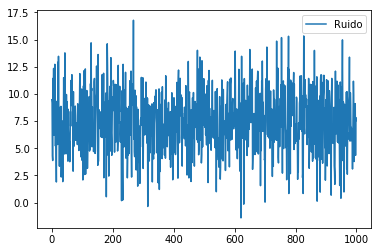

In [9]:
%matplotlib inline

import random
import pandas

numbers = [random.gauss(7.5, 2.8) for i in range(1000)]
df = pandas.DataFrame(data=numbers, columns=['Ruido',])
df.plot()

Veamos el histograma para apreciar la campana de Gauss:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c4a3b2a20>]], dtype=object)

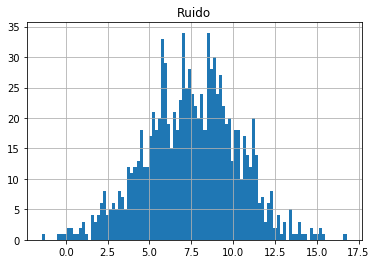

In [10]:
df.hist(bins=100)

### <a name="collections"></a>El módulo collections: Otras estructuras de datos <a href="#top">▲</a>

Este módulo implemente ciertos contendores especializados a partir de los básicos: dicionarios, listas, conjunto y tuplas. Algunas de las más interesantes son las siguientes:

#### <a name="namedtuple"></a> Namedtuple

Con **`namedtuple`** podemos crear un tipo especial de tuplas cuyo contenido puede ser accedido tanto por posición como por nombre. Llamamos a `namedtuple` para crear una clase que luego puede ser usada para crear instancias de tuplas. Se comprende mejor con un ejemplo:

In [11]:
from collections import namedtuple

Superhero = namedtuple('Superhero', 'name identity city')  # nombre de la clase y atributos aceptados

batman = Superhero(name='Batman', identity='Bruce Wayne', city='Gotham City')
assert batman.name == batman[0]
assert batman.identity == batman[1]
assert batman.city == batman[2]
wonder_woman = Superhero('Wonder Woman', 'Diana Prince', 'Boston') # Creación por posición
print(batman, wonder_woman, sep='\n')


Superhero(name='Batman', identity='Bruce Wayne', city='Gotham City')
Superhero(name='Wonder Woman', identity='Diana Prince', city='Boston')


Es una forma rápida de crear una estructura, para aquellos casos en que no es necesario crear una clase completa. Por ejemplo, se puede usar para leer el contenido de un fichero en formato .CSV como una serie de _namedtuples_, accesibles tanto por posición como por el nombre de la columna. Siempre se puede reemplazar en el futuro por una clase completa, si fuera necesario.

#### <a name="deque"></a> deque


La estrutura de datos **`deque`** sirve para mejorar el rendimiento de las listas en aquellos casos en los que no nos interesa el acceso a los contenidos de la lista por posición, sino solo nos interesa trabajar con los extremos de la lista, es decir, que usamos solo operaciones de tipo `append`, `insert` o `pop`, pero nunca accedemos por posición.

Con una lista podemos obviamente hacer un `pop(0)`, pero la lista incurre en una carga extra, porque al eliminar el primer elemento tienen que recolocar todos los demás elementos de la lista (El segundo pasa a ser el primero, el tercero pasa al segundo, etc...), lo que implica que la lista realiza O(n) movimientos de memoria. Con `deque`, que se implementa en forma de lista doblemente enlazada, la operación es de coste fijo. 

Veamos un ejemplo para medir el rendimiento:

In [12]:
from collections import deque

list_items = list(range(100000))
%time list_items.pop(0) == 0

deque_items = deque(range(100000))
%time deque_items.popleft() == 0


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 67.2 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


True

Como vemos, una mejora importante. Si en vez de trabajar con 100000 elementos fueran un millón, el resultado sería aun más espectacular. En resumen, `deque` es una doble lista encadenada especializada en realizar las operaciones de añadir o quitar de los extremos con rapidez.

#### <a name="Counter"></a> Counter

la clase **`Counter`** es un tipo especial derivado del diccionario que está especializado en llevar cuentas; asocia a cada clave un contador y tienen métodos adicionales para este tipo de estructura de datos. Es equivalente en otros lengajes al concepto de _multisets_ o multiconjuntos. Veamos un ejemplo:

In [13]:
from collections import Counter

c = Counter('abracadabra pata de cabra')
print(c)

Counter({'a': 9, ' ': 3, 'b': 3, 'r': 3, 'c': 2, 'd': 2, 'e': 1, 't': 1, 'p': 1})


Por ejemplo, si quisieramos descubrir las 25 palabras más usadas en el prólogo del señor de los anillos, podriamos hacer:

In [14]:
# Primero definimos una función para eliminar caracteres molestos y
# que nos devuelva el texto en forma de listas de palabras en minusculas

import re

def limpia_texto(texto):
    pat_exclude = re.compile('[ ".,\:;\-\(\)]+')  # Caracteres a ignorar
    result = pat_exclude.split(texto)
    return [w.lower() for w in result if w]

assert  limpia_texto('Hola. Me llamo "Iñigo Montoya"') == ['hola', 'me', 'llamo', 'iñigo', 'montoya']
assert  limpia_texto('Tú mataste -a mi padre-') == ['tú', 'mataste', 'a', 'mi', 'padre']
assert  limpia_texto('(Prepárate a: morir)') == ['prepárate', 'a', 'morir']


In [15]:
# Ahora le pasamos el texto en forma de lista a un objeto de la clase Counter
# y le pedimos las 25 palabras más usadas

from collections import Counter

with open('data/prologo.txt', 'r', encoding='utf-8') as f:
    words = limpia_texto(f.read())
    
c = Counter(words)
print(c.most_common(25))

[('de', 408), ('y', 273), ('la', 237), ('en', 234), ('los', 226), ('que', 170), ('el', 149), ('a', 131), ('se', 105), ('las', 101), ('del', 85), ('no', 56), ('más', 56), ('un', 51), ('hobbits', 50), ('por', 49), ('lo', 48), ('con', 43), ('pero', 39), ('comarca', 38), ('como', 38), ('bilbo', 37), ('una', 35), ('o', 35), ('había', 32)]


Quitando las palabras aburridas (el, la, los, las, un, etc...), la más mencionada es _hobbits_. ¿Cuántas veces aparecen las palabras "elfo" o "elfos"?

In [16]:
print(c['elfo'] + c['elfos'])

13


#### <a name="OrderedDict"></a> OrderedDict

Un diccionario de la clase **`OrderedDict`** es igual que cualquier otro diccionario con la salvedad de que recuerda el orden en que se han insertado las claves, de forma que cuando se recorre, se sigue ese mismo orden (En un diccionario estandar, no se garantiza el orden). Podemos crear el diccionario a partir de una lista de tuplas, por ejemplo.

In [17]:
from collections import OrderedDict

d = OrderedDict([('I', 1), ('II', 2), ('III', 3), ('IV', 4), ('V', 5), ('VI', 6), ('VII', 6)])
for k in d:
    print(k, ':', d[k])

I : 1
II : 2
III : 3
IV : 4
V : 5
VI : 6
VII : 6


####  <a name="defaultdict"></a> defaultdict

La clase **`defaultdict`** nos permite especificar, al crear una instancia, una función que se llamara cuando no se encuentre una clave, almacenándose el resultado de esa llamada en la clave. Un caso muy usado es cuando queremos un diccionario de listas. Veamos un ejemplo:


In [18]:
from collections import defaultdict

d = defaultdict(list)  # list es una función predefinida que crea una lista. 
d['a'].append('alfa')
d['a'].append('amigo')
d['b'].append('bingo')

print(d)
print(d['a'], d['b'], d['c'])  # ❶
print(d)

defaultdict(<class 'list'>, {'a': ['alfa', 'amigo'], 'b': ['bingo']})
['alfa', 'amigo'] ['bingo'] []
defaultdict(<class 'list'>, {'c': [], 'a': ['alfa', 'amigo'], 'b': ['bingo']})


Cada vez que intentemos acceder a un elemento  con una clave inexistente, se creará una lista vacía, porque ese es el resultado de ejecutar `list` sin parámetros. Por eso al acceder en la línea ❶ a la clave `c`, aunque no hicimos nada, se creo automaticamente la lista vacia. Podemos usar cualquier funcion que deseemos, siempre que se pueda llamar sin parámetros.

## Trabajar con fechas y tiempos

### <a name="time"></a> El módulo time  <a href="#top">▲</a>

Esté modulo proporciona funciones para trabajar con tiempos y fechas. La mayoría de las funciones realizan llamadas al S.O. subyacente.

Algunas consideraciones y terminología:

- **UTC** es el tiempo coordinado Universal, anteriormente conocido como GMT o Hora de Greenwich (El acrónimo UTC es un comprimiso entre el inglés y el francés)

- **DST** es el ajuste de horario de verano (_Daylight Saving Time_) una modificacion de la zona horaria, normalmente de una hora, que se realiza durante parte del año. las reglas de los DST son, en la práctica, pura magia (dependen de las leyes locales) y pueden cambiar de año a año

Los valores de tiempo devueltos por `gmtime()`, `localtime()` y `strptime()`, y aceptados por `asctime()`, `mktime()` y
`strftime()` son tuplas (En realidad, `namedtuple`) de 9 enteros, por este orden: año, mes, dia, horas, minutos, segundos, día de la semana, día dentro del año y un indicador de si se aplica o no el horario de verano.

Algunas funciones definidas en este módulo:

- **`time.time()`** : Devuelve el tiempo en segundos, en forma de número de coma flotante.


- **`time.gmtime([secs])`** : Convierte  un tiempo en segundos en una tupla de nueve elementos, en los cuales el flag final es siempre 0. Si no se indica el tiempo , se tomará el momento actual.

- **`time.localtime([secs])`** : Como `gmtime()`, pero convertido a tiempo local. El indicador final se pone a uno si en ese momento estaba activo el horario de verano.

- **`time.mktime(t)`** : La inversa de `localtime()`. Su argumento es una tupla de 9 elementos (Como el flag final es obligatorio, se puede poner -1 para indicar que no lo sabemos). Devuelve un [tiempo Unix o POSIX](https://es.wikipedia.org/wiki/Tiempo_Unix): El número de segundos trascurridos desde la medianoche UTC del 1 de enero de 1970.

- **`time.sleep(secs)`** : Suspender la ejecución del programa durante el tiempo en segundos indicado como parámetro.

#### Ejercicio: Determinar el dia de la semana de una fecha

Escribir una función que, pasandole año, mes y día nos devuelva el día de la semana que corresponde. Usarlo para averiguar que día de la semana era el día que cayó el [Muro de Berlín](https://es.wikipedia.org/wiki/Muro_de_Berl%C3%ADn) (9 de noviembre de 1989) (O cualquier otra fecha que les interese).

### Solución

Podemos usar las funciones `mktime`, que nos permite pasar -1 para los valores que a priori desconocemos, obtener los segundos en tiempo UNIX, y a partir de esos segundos volver a obtener una tupla con los valores correctos en los tres ultimos _flags_. Sabiendo que el lunes se considera el día 0, una solución podría ser:

In [19]:
import time

def date_to_weekday(year, month, day):
    weekdays = ['lunes', 'martes', 'miércoles', 'jueves', 'viernes', 'sábado', 'domingo']
    t = (year, month, day, 12, 0, 0, -1, -1, -1)
    num_secs = time.mktime(t)
    dt = time.gmtime(num_secs)
    return weekdays[dt[6]]

print('El muro de Berlín cayó un', date_to_weekday(1989, 11, 9))

El muro de Berlín cayó un jueves


###  <a name="datetime"></a> El módulo datetime <a href="#top">▲</a>

El módulo `datetime` continua donde lo deja `time`. Proporciona  clases para trabajar con fechas y tiempos, soportando por ejemplo aritmética de fechas.

La clase `datetime` sirva para trabajar con fechas y horas. Para trabajar con estos objetos hay que saber que podemos tener derivar dos tipos distintos de fechas/horas a partir de esta clase: las fechas absolutas o relativas.

Una fecha absoluta dispone de toda la información necesaria para poder determinar, sin ninguna ambigüedad, su valor. Sabe por tanto en que zona horaría está y, lo que es más complicado, si está activo o  no el horario de verano. El horario de verano es un acuerdo político, administrado por cada país, por lo que suele ser cambiante, difícil de entender y, en general, caótico. La ventaja de este tipo de fecha/hora es que no está sujeta a interpretación.

Una fecha relativa, por el contrario, no tienen toda la información necesaria para que su valor sea indiscutible, lo que dificulta, por ejemplo, hacer comparaciones. Determinar si una fecha relativa está referida al Tiempo Coordinado Universal (UTC), la fecha y hora local o la fecha y hora en alguna otra zona horaria depende por entero del
programa, de la misma forma que es responsabilidad del programa determinar si un número representa metros, micras o litros. Las fechas/tiempo locales son fáciles de entender y de usar, pero tenemos que pagar el coste que supone ignorar ciertos aspectos  de la realidad.

Los tipos disponibles en este módulo son:

- **`class datetime.date`** : Una fecha local, que asume que el [Calendario Gregoriano](https://es.wikipedia.org/wiki/Calendario_gregoriano) siempre ha estado y estará vigente. Tiene los atributos: `year`, `month` y `day`. Se le puede llamar pasandole los tres parámetros, año, mes y dia. Si queremos obtener la fecha de hoy podemos llamar a la función de clase `datetime.date.today()`.

- **`class datetime.time`** : Una marca de tiempo ideal, no sujeta a ninguna fecha en particular, y que asume que cada día tiene exactamente 24*60*60 segundos. Tiene los atributos: `hour`, `minute`, `second`, `microsecond` y `tzinfo`.

- **`class datetime.datetime`** :  Combinación de fecha y hora, con los atributos: `year`, `month`, `day`, `hour`, `minute`, `second`, `microsecond` y `tzinfo`. Podemos obtener el momento actual llamando al mñétodo de clase `datetime.datetime.now()`.

- **`class datetime.timedelta`** : Representa una duración: La diferencia entre dos objetos de tipo `date` o `datetime`.

Estos tipos de datos son todos inmutables.

#### Ejercicio: ¿Qué día de la semana es hoy?

Usar la función definida en el ejercicio anterior para saber que día de la semana es hoy.

#### Solución

Podemos usar `datetime.date.today()` para obtener la fecha de hoy, y a partir del año, mes y día es trivial obtener el día de la semana:

In [20]:
import datetime

hoy = datetime.date.today()
print('Hoy es', date_to_weekday(hoy.year, hoy.month, hoy.day))

Hoy es martes


## Trabajar con ficheros

### <a name="xml"></a>El paquete xml <a href="#top">▲</a>

Los diferentes módulos de Python para trabajar con ficheros XML están agrupados en el paquete `xml`. Las dos formas más habituales de trabajar con un fichero XML son DOM (:term:`Document Object Model`) y SAX (:term:`Simple API for XML`). Ambas están disponibles en los módulos `xml.dom` y `xml.sax` respectivamente.

Usando el modelo DOM tenemos acceso a todo el árbol de una sola vez, lo que puede ser costoso en terminos de almacenamiento en memoría. Con SAX procesamos el árbol paso a paso, respondiendo ante ciertos eventos, a medida que se van abriendo y cerrando los nodos. Con esta segunda forma perdemos cierta flexibilidad pero no tenemos el problema del almacenamiento completo del árbol en memoria.

XML es un formato de datos jerárquico, con lo que la forma maás habitual de representarlo es un árbol. Para eso se definen las clases `ElementTree`, que representa todo el documento XML a tratar, y `Element`, que representa a un nodo dentro del árbol. Las interacciones con el documento como un todo, como por ejemplo leerlo o guardarlo en un fichero en disco, se hacen normalmente a nivel de `ElementTree`. Las interacciones con un elemento XML o sus subelementos se realizan en el nivel de `Element`.

Usaremos para explicar estos módulos el siguiente documento XML:

In [21]:
!cat data/country_data.xml

<?xml version="1.0"?>
<data>
    <country name="Liechtenstein">
        <rank>1</rank>
        <year>2008</year>
        <gdppc>141100</gdppc>
        <neighbor name="Austria" direction="E"/>
        <neighbor name="Switzerland" direction="W"/>
    </country>
    <country name="Singapore">
        <rank>4</rank>
        <year>2011</year>
        <gdppc>59900</gdppc>
        <neighbor name="Malaysia" direction="N"/>
    </country>
    <country name="Panama">
        <rank>68</rank>
        <year>2011</year>
        <gdppc>13600</gdppc>
        <neighbor name="Costa Rica" direction="W"/>
        <neighbor name="Colombia" direction="E"/>
    </country>
</data>

Lo más básico es importar y leer estos datos desde un fichero. Lo podemos hacer con el siguiente código:

In [22]:
import xml.etree.ElementTree as ET

tree = ET.parse('data/country_data.xml')
root = tree.getroot()
print(root)

<Element 'data' at 0x7f0c4a204f48>


O también podemos leer los datos a partir de una variable de tipo _string_:

In [23]:
with open('data/country_data.xml', 'r', encoding='utf-8') as f:
    country_data_as_string = f.read()

root = ET.fromstring(country_data_as_string)
print(root)

<Element 'data' at 0x7f0c4a20a408>


Como `root` es un elemento (un objeto de la clase `Element`), tiene una etiqueta, `tag` y un conjunto de atributos, en forma de diccionario, `attrib`:

In [24]:
print(root.tag, root.attrib)

data {}


Tambien tiene una serie de hijos, sobre los que podemos iterar:

In [25]:
for child in root:
    print(child.tag, child.attrib)

country {'name': 'Liechtenstein'}
country {'name': 'Singapore'}
country {'name': 'Panama'}


También podemos acceder a los hijos usando índices:

In [26]:
print(root[0][1].text)

2008


La clase `Element` define una serie de método que nos ayudan a recorrer recursivamente todo el subárbol que haya debajo de él (Sus hijos, nietos, etc...). Por ejemplo, el método `iter()`:

In [27]:
for neighbor in root.iter('neighbor'):
    print(neighbor.attrib)

{'direction': 'E', 'name': 'Austria'}
{'direction': 'W', 'name': 'Switzerland'}
{'direction': 'N', 'name': 'Malaysia'}
{'direction': 'W', 'name': 'Costa Rica'}
{'direction': 'E', 'name': 'Colombia'}


El método `Element.findall()` localiza sólo los elementos de una determinada etiqueta que son hijos directos del nodo actual. El método `Element.find()` encuentra el primer hijo que cumpla esta misma condición. Con `Element.text` podemos acceder al contenido textual del elemento, y con `Element.get` podemos acceder a los valores de sus atributos:

In [28]:
for country in root.findall('country'):
    rank = country.find('rank').text
    name = country.get('name')
    print('El ranking de', name, 'es', rank)

El ranking de Liechtenstein es 1
El ranking de Singapore es 4
El ranking de Panama es 68


Se pueden hacer operaciones de búsqueda aun más sofisticadas usando [Xpath](http://en.wikipedia.org/wiki/XPath).

### <a name="csv"></a>El paquete csv <a href="#top">▲</a>

El formato de fichero llamado **CSV** (_Comma Separated Values_ o Valores separados por comas) es uno de los más usados para el intercambio de información de hojas de cálculo o bases de datos. A pesar de eso, no hay ningún estandar ni norma escrita, así que el formato esta definido de forma más o menos informal por el conjunto de aplicaciones que pueden leerlo o escribirlo.

Esta carencia de estandares provoca que haya multiples, inesperadas y pequeñas diferencias entre los datos producidos o consumidos por diferentes aplicaciones. Por esta razón, trabajar con distinto ficheros CVS provinientes de distintas fuentes suele dar más de un dolor de cabeza. A pesar de estas divergencias (empezando por que caracter usar como separador de campos), es posible escribir un módulo que pueda maniputar de forma eficiente estos datos, ocultado al programador los detalles específicos de leer o escribir estos ficheros,

![Su carencia de estándares...](img/estandares.png)

El módulo csv permite escribir y leer estos archivos. El programador puede especificar, por ejemplo, "escribe este archivo en el formato preferido por excel", o "lee este fichero como fuera de excel, pero usando el carácter `:` como separador de campos". También nos permite definir nuestros propios formatos de uso particular, que el módulo denomina "dialectos".

Las funciones `reader()` y `writer()` leen y escriben secuencias.

Vamos a trabajar con un sencillo fichero, couyo contenido es el siguiente:

In [29]:
!cat data/star-trek-crew.csv

Range; Name; Race; Starship; Level
Captain; James T. kirk; Human; USS Enterprise (NCC-1701); 92
First officer: Spock; Vulcan; USS Enterprise (NCC-1701); 88
Chief medical officer; Human; Leonard McCoy; USS Enterprise (NCC-1701); 87
Communications officer; Human; Nyota Uhura; USS Enterprise (NCC-1701); 88
Navigator; Human; Pavel Chekov; USS Enterprise (NCC-1701); 72
Science officer; Michael Burnham; Vulcan; USS Discovery (NCC-1031); 0
Captain; Gabriel Lorca; Human; USS Discovery (NCC-1031); 99
First officer; Saru; Kelpien; USS Discovery (NCC-1031); 98


Un ejemplo sencillo de lectura:

In [30]:
import csv

with open('data/star-trek-crew.csv', 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=';')
    for row in reader:
        print(row)

['Range', ' Name', ' Race', ' Starship', ' Level']
['Captain', ' James T. kirk', ' Human', ' USS Enterprise (NCC-1701)', ' 92']
['First officer: Spock', ' Vulcan', ' USS Enterprise (NCC-1701)', ' 88']
['Chief medical officer', ' Human', ' Leonard McCoy', ' USS Enterprise (NCC-1701)', ' 87']
['Communications officer', ' Human', ' Nyota Uhura', ' USS Enterprise (NCC-1701)', ' 88']
['Navigator', ' Human', ' Pavel Chekov', ' USS Enterprise (NCC-1701)', ' 72']
['Science officer', ' Michael Burnham', ' Vulcan', ' USS Discovery (NCC-1031)', ' 0']
['Captain', ' Gabriel Lorca', ' Human', ' USS Discovery (NCC-1031)', ' 99']
['First officer', ' Saru', ' Kelpien', ' USS Discovery (NCC-1031)', ' 98']


Y uno de escritura:

In [31]:
import sys
import csv

datos = [
    ('Leonardo', 'Azul', 1452),
    ('Raphael', 'Rojo', 1483),
    ('Michelangelo', 'Naranja', 1475),
    ('Donatello', 'Violeta', 1386),
    ]

writer = csv.writer(sys.stdout, delimiter='\t', quoting=csv.QUOTE_NONNUMERIC)
writer.writerows(datos)

"Leonardo"	"Azul"	1452
"Raphael"	"Rojo"	1483
"Michelangelo"	"Naranja"	1475
"Donatello"	"Violeta"	1386


Módulos para trabajar con ficheros comprimidos
-----------------------------------------------------------------------

### <a name="zipfile">El módulo zipfile — Soporte para archivos ZIP</a> <a href="#top">▲</a>

El archivo ZIP es un formato estándar de archivado y compresión de archivos. Este módulo proporciona mecanismos para crear, leer, escribir, modificar y listar archivos ZIP. Soporta trabajar con ficheros ZIP cifrados, pero por el momento no puede crearlos. El descifrado es particularmente lento, porque no está implementado en C.

La función `is_zipfile()` devuelve un booleno indicando si el fichero que se le pasa como parámetro es un archivo ZIP o no.

La clase `ZipFile` nos permite trabajar directamente con un archivo ZIP. Tiene métodos para obtener información sobre los ficheros contenidos en el archivo, así como para añadir nuevos ficheros a un archivo.

Por ejemplo, para leer los nombres de los ficheros contenidos enun archivo ZIP, podemos hacer:

In [32]:
import zipfile

zf = zipfile.ZipFile('data/data.zip', 'r')
for fn in zf.namelist():
    print(fn)

country_data.xml
star-trek-crew.csv


#### Ejercicio: Buscar y listasr contenido de archivos Zip

Usando la funcion `walk` del módulo `os.path`, hacer una utilidad que busque a partir de un directorio todos los ficheros zip y liste su contenido.

In [33]:
!cat ejercicios/find_zips.py

#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import print_function
from __future__ import absolute_import
from __future__ import division
from __future__ import unicode_literals

import os
import zipfile

def find_zip():
    for (dirpath, dirnames, filenames) in os.walk('.'):
        for filename in filenames:
            if filename.lower().endswith('.zip'):
                fullname = os.path.join(dirpath, filename)
                yield fullname

if __name__ == '__main__':
    print('Buscando ficheros zip')
    for fn in find_zip():
        print('Fichero:', fn)
        zf = zipfile.ZipFile(fn, 'r')
        for fn in zf.namelist():
            print(' - {}'.format(fn))
        print('-'*80)

### <a name="gzip"></a>El módulo gzip - Soporte para ficheros gzip  <a href="#top">▲</a>

El módulo `gzip` nos proporciona los medios para comprimir o descomprimir ficheros igual que lo hacen los programas unix `gzip` y `gunzip`. Al contrario que con el formato ZIP,  el formato gzip solo permite comprimir y descomprimir un fichero, porque no tiene capacidad de archivado (Es decir, la posibilidad de añadir varios ficheros dentro del archivo).

El módulo `gzip` proporciona la clase `GzipFile`, que imita a un objeto de tipo `file` de Python. Los objetos instanciados de esta clase leen y escriben ficheros con el formato gzip. La compresión y descompresión es realizada automáticamente, por lo que el programandor puede trabajar con el fichero como si fuera un fichero normal.

Veamos un ejemplo de como crear un fichero comprimido con gzip:

In [34]:
import gzip

content = "Lots of content here"
f = gzip.open('data/file.txt.gz', 'w')
f.write(content.encode('utf-8'))
f.close()

Un ejemplo  de como leer un fichero comprimido:

In [35]:
import gzip

with gzip.open('data/file.txt.gz', 'rt', encoding='utf-8') as f:
    file_content = f.read()

print(file_content)

Lots of content here


Como comprimir un fichero ya existente (por defecto gzip asume ficheros binarios, si queremos un fichero de texto y que haga las conversiones automaticas a utf-8 hay que usar los modos `rt` o `wt`:

In [36]:
import gzip
with open('data/prologo.txt', 'r', encoding='utf-8') as f_in:
    with gzip.open('data/prologo.txt.gz', mode='wt', encoding='utf-8') as f_out:
        f_out.writelines(f_in)
!ls data/*.gz

data/file.txt.gz  data/prologo.txt.gz


## Internet

En la librería estandar vienen incluidos varios módulos muy potentes para trabajar con recurosos de Internet.


### <a name="urllib.request"></a> El módulo urllib.request — Librería para abrir URLs  <a href="#top">▲</a>

El módulo `urllib.request` define funciones y clases que nos ayudan a abrir recursos en Intenet, URL, en su mayoría usando el protocolo HTTP, incluyendo algunos aspectos un poco más comlpejos, como autentificación, redirecciones, _cookies_, etc...

> Nota : Diferencias entre Python 2.x / Python 3.x

  Los contenidos de los módulos `urllib.request` y `urllib.error`, en python 2.x se encontraban en un solo módulo, `urllib2`. La herramienta `2to3` adapta automáticamente estos imports, o podemos usar `six` para importar de igual manera en ambas versiones: `form six.moves import urllib`.
 
Este módulo nos permite abrir y trabajar con direcciones de internet
(URLs). La función más usada del módulo es la siguiente:

    urllib.request.urlopen(url[, data][, timeout])

Que abre la url indicada, dandonos un objeto similar a un fichero. Por ejemplo, podemos realizar una consulta a Google con el siguente código:

In [37]:
from IPython.display import display, HTML

display(HTML('<p>hola <b>nn</b<</p>'))

In [38]:
import urllib

r = urllib.request.urlopen('http://www.pythoncanarias.es/')
page = r.read().decode('utf-8')
pat_titulo = re.compile('<title>([^<]+)</title>', re.IGNORECASE)
m = pat_titulo.search(page)
print(m.group(1) if m else 'Título no encontrado')


Python Canarias - Comunidad de entusiastas del lenguaje Python.


En el parámetro opcional `data` podemos incluir información adicional  que requieren ciertas peticiones web, especialmente las que usan el verbo `POST`. Si se incluye, `data` debe estar formateada con el estándar  `application/x-www-form-urlencoded`, algo que podemos conseguir usando la función `urllib.parse.urlencode()`, que acepta como
parámetro un  diccionario o una secuencia de parejas (2-tuplas), y devuelve una string en ese formato.

El otro parámetro opcional, `timeout`, indica el tiempo en segundos que debemos esperar antes de descartar por imposible una conexión.

El objeto devuelto, además de comportarse como un archivo y como un _context manager_, dispone de métodos como:

 - **`geturl()`** : Devuelve la URL del recurso recuperado. Esto se utiliza normalmente para determinar si ha habido alguna clase de recirección.

- **`info()`** : Devuelve la meta-información sobre el recurso solicitado, como las cabeceras, en forma de una instancia de la clase `mimetools.Message`.

- **`getcode()`** : Devuelve el código de estado del protocolo HTTP de la respuesta.

#### Ejercicio: Salvar una página de Internet en un fichero local

POr ejemplo, la de Python: <http:www.python.org>

#### Solución

In [39]:
import urllib

url = 'http://www.python.org/'
with urllib.request.urlopen(url) as source:
    with open('data/python-homepage.html', 'w', encoding='utf-8') as target:
        for linea in source.readlines():
            target.write(linea.decode('utf-8'))
!ls -la data/*.html

-rw-rw-r-- 1 jileon jileon 48853 nov 21 10:58 data/python-homepage.html


### <a name="smtplib"></a>El módulo smtplib — cliente de protocolo SMTP (Correo)  <a href="#top">▲</a>

El módulo `smtplib` define un cliente del protocolo **SMTP** (_Simple Mail TRansfer Protocol_), que puede ser usado para enviar correo  electrónico a cualquier ordenador en Internet que esté ejecutando un demonio SMTP o ESMTP.

El siguiente ejemplo compone un mensaje, ayudándose de la clase `Message` definido en `email.message`. Las variables
`gmail_user` y `gmail_password` están definidas en el código, lo que en general es muy mala idea. Una vez creado el mensaje, se realiza la conexión al servidor de correo, que en este caso es el de Google Mail. La conexión en este caso es un poco más complicada de lo que sería con un servidor SMTP local, en la que la seguridad a lo mejor es un poco más laxa:

In [40]:
from email.message import Message
from smtplib import SMTP

gmail_user = ''  # Pon aqui tu nombre de usuario
gmail_password = ''  # pon aqui tu contraseña

if all({gmail_user, gmail_password}):
    # Creamos el mensaje
    msg = Message()
    msg['to'] = 'euribates+test@gmail.com'
    msg['from'] = 'euribates@gmail.com'
    msg['subject'] = 'Esto es una prueba!'
    msg.set_payload('Hola, mundo\n\n-- Juan')

    # Lo enviamos
    print('Enviando correo', end=' ')
    smtpserver = SMTP("smtp.gmail.com", 587)
    smtpserver.ehlo()
    smtpserver.starttls()
    smtpserver.ehlo
    smtpserver.login(gmail_user, gmail_password)
    smtpserver.sendmail(gmail_user, msg['to'], msg.as_string())
    smtpserver.close()
    print('[OK]')
else:
    print('No puedo enviar correo sin unas credenciales válidas')

No puedo enviar correo sin unas credenciales válidas


Aunque el formato de los mensajes es realmente sencillo, usar la clase `Message` nos permite incluir de forma rápida y sencilla funcionalidades más elaboradas, como anexar ficheros o enviar múltiples versiones del mismo contenido.

### <a name="http.server"></a> El modulo http.server - Un servidor web  <a href="#top">▲</a>

> **Nota: Diferencias entre Python 2.x / Python 3.x:**
> En Python2.x el módulo `http.server` se llamaba `SimpleHTTPServer`. La herramienta `2to3` adapta automáticamente estos imports, o podemos user `six` para que el código funcione en ambas plataformas 

Este módulo define una serie de clases que nos permiten  implementar nuestros propios servidores web. La clase SimpleHTTPRequestHandler definida en `http.server` (En el módulo `SimpleHTTPServer` en Python 2.x) es un servidor de ejemplo básico que sirve los ficheros del directorio donde se ha ejecutado, mapeando la estrucura de directorios como páginas web.

La mayor parte del trabajo, como analizar las peticiones, por ejemplo, lo hace la clase de la que deriva, `BaseHTTPServer`, la clase de ejemplo solo tienen que sobreescribir los métodos `do_GET()` y `do_HEAD()`.

El siguiente programa usa la clase de ejemplo para arrancar un
servidor web básico, escuchando en la máquina local y en el puerto
8000:

In [41]:
!cat ejercicios/http_server.py

#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from http.server import HTTPServer
from http.server import SimpleHTTPRequestHandler

if __name__ == '__main__':
    server_address = ('localhost', 8080)
    httpd = HTTPServer(server_address, SimpleHTTPRequestHandler)
    print('Serving at {}'.format(server_address))
    httpd.serve_forever()



Arrancarlo dentro de Jupyter puede ser un poco complicado, sobre todo para poder abortarlo, pero se puede ejecutar desde la shell sin problemas, y abortarlo con CTL-C, o ajecutar la línea siguiente (Para parar el servidor dentro de Jupyter, ir al menu Kernel -> Interrupt:

In [42]:
!python3 ejercicios/http_server.py

Traceback (most recent call last):
  File "ejercicios/http_server.py", line 9, in <module>
    httpd = HTTPServer(server_address, SimpleHTTPRequestHandler)
  File "/usr/lib/python3.5/socketserver.py", line 441, in __init__
    self.server_activate()
  File "/usr/lib/python3.5/socketserver.py", line 463, in server_activate
    self.socket.listen(self.request_queue_size)
OSError: [Errno 98] Address already in use


Pero puede ser aun más fácil, usando la opcion `-m` en el  interprete para que ejecute el módulo como si fuera
el programa principal, y opcionalmente indicando el número de puerto al que se vincula el servidor.

Para Python 3.x:

    $ python3 -m http.server 8000
    
Para Python 2.x:

    $ python -m SimpleHTTPServer 8000


### <a name="hashlib"></a>El módulo hashlib - hashes y códigos de verificación e integridad <a href="#top">▲</a>

El módulo `hashlib` define una interfaz común a una serie de algoritmos conocidos como _funciones de hash criptográficos_ o _funciones resumen_: SHA1, SHA224, SHA256,  SHA384 y SHA512, así como el algoritmo MD5 de RSA (Definido como estándar en el RFC 1321).

Su uso en muy sencillo: Por ejemplo, usamos `new('<name>')` para crear un objeto, donde $name$ es el nombre de un algoritmo conocido e imlpementado en la librería, como por ejemplo `md5`. A partir de ahi, podemos ir actualizando los datos sobre los que se tienen que hacer el *hash* con sucesivas llamadas a su método `update()`. Hacer una serie de llamadas sucesivas con partes del texto es equivalente a hacer un solo `update()` con todo el texto concatenado en un único valor; en otras palabras:

In [43]:
import hashlib

a = b'hola, '
b = b'mundo'

m1 = hashlib.new('md5')
m1.update(a)
m1.update(b)

m2 = hashlib.new('md5')
m2.update(a + b)

assert m1.hexdigest() == m2.hexdigest() == '3f687c859595879530a6a8c0062b1563'
print(m1.hexdigest(), m2.hexdigest(), sep='\n')

3f687c859595879530a6a8c0062b1563
3f687c859595879530a6a8c0062b1563


Podemos ir actualizando poco a poco con el método `update` o se pueden suministrar todos los datos en la llamada a `new`. Por ejemplo, para obtener el *hash* criptográfico de la frase "Su teoría es descabellada, pero no lo suficente para ser correcta.", podemos hacer:

In [44]:
import hashlib

m1 = hashlib.new('md5')
m1.update("Su teoría es descabellada".encode('utf-8'))
m1.update(b", pero no lo suficente")
m1.update(b" para ser correcta.")

m2 = hashlib.new('md5', 'Su teoría es descabellada, pero no lo suficente para ser correcta.'.encode('utf-8'))

assert m1.hexdigest() == m2.hexdigest() == '46c8a761de36c7306532ae6f1013164c'
print(m1.hexdigest(), m2.hexdigest(), sep='\n')

46c8a761de36c7306532ae6f1013164c
46c8a761de36c7306532ae6f1013164c


El código obtenido depende de los datos suministrados, de forma que cualquier alteración, por mínima que sea, en el texto original, provocará una alteración enorme en el código de salida. Por ejemplo, veamos como cambia el resultado simplemente cambiando una coma de lugar:

In [45]:
import hashlib

m1 = hashlib.new('md5', 'Perdón imposible, ejecutar prisionero'.encode('utf-8'))
m2 = hashlib.new('md5', 'Perdón, imposible ejecutar prisionero'.encode('utf-8'))

assert m1.hexdigest() != m2.hexdigest()
print(m1.hexdigest(), m2.hexdigest(), sep='\n')

eafd88022b53be13af86520a6a221024
2b4360dbca5fd7b7b5df3fc4af7bab24


> **Nota: El ejemplo se basa en una anécdota apócrifa atribuida al emperador Carlos V, de la que circulan varias versiones. Ésta es una de ellas:**
> Estando el rey en el teatro, le recordaron que tenía que decidir si indultaba o no a un condenado a muerte, decisión que había aplazado en su última audiencia, pero que ahora corría prisa, pues la ejecución estaba prevista para el día siguiente. Como respuesta, escribió en un billete: "Perdón imposible ejecutar al reo". El secretario que llevaba el papel se dió cuenta de que la vida del prisionero estaba en sus manos, y dependía de dónde se añadiese la coma que, evidentemente, faltaba. Si se decía "Perdón imposible, ejecutar al reo", el condenado era hombre muerto, pero si se escribía "Perdón, imposible ejecutar al reo", se salvaba.

### <a name="timeit"></a> timeit - Optimización de rendimiento  <a href="#top">▲</a>


Para algunos usuarios de Python el rendimiento es una preocupación
fnudamental, y están interesados es poder medir la diferencia
de rendimiento entre opciones alternativas. Python proporciona
varias maneras de poder resolver estas preguntas, siendo una de las
más sencillas el módulo `timeit`.

pero antes, un consejo:

> **La optimización prematura es la raíz de todo mal**
> Donald Knuth "Structured Programming with go to Statements".

> Hay que entender que sin medidas precisas y globales del rendimiento de la aplicación, no debemos optimizar. Hay optimizaciones triviales, como por  ejemplo no concatenar cadenas de texto (mejor ir añadiendolas a una lista y usar `join()` para obtener la cadena de texto final), pero a no ser que sean realmente obvias, las optimizaciones deben esperar hasta que podamos medir el desempeño en un contexto global. La herramienta que realiza estas medidas se conocen como *profiler*.

> El peligro de optimizar sin este conocimiento es que no sabemos que parte del código es la que realmente demanda nuestros esfuerzos de mejora. Podemos acabar complicando una parte del código que, en realidad, solo es responsable del 1% del tiempo de ejecución. Eso significa que si consiguieramos, por ejemplo, optimizar esa parte del código para que vaya el doble de rápido (Una optimización del 200%, realmente  impresionaante y nada habitual) el resultado neto sería una mejora de un 0.005% en el rendimiento total. De hecho, si consiguieramos una mejora espectacular, que ese código se ejecute en, digamos, 0.001 nanosegundos, aun así, la mejora en el redimiento total nunca superará el 1%. A cambio, tenemos software más complejo, más difícil de leer y con mayor capacidad potencial de errores.

El módulo **`timeit`** permite obtener una medida fiable de los los tiempos de ejecución de un fragmento de código Python.

Vimos en su día que había dos formas de intercambiar los valores de dos variables, usando una variable auxiliar o usando el mecanismo de empaquetado de tuplas:

In [46]:
# Usando una variable auxiliar
a = 7
b = 12
temp = a
a = b
b = temp
assert a == 12
assert b == 7

# Usando tuplas
a = 7
b = 12
a, b = b, a
assert a == 12
assert b == 7

Pero ¿cuál será más rápida? Usando el módulo `timeit` podemos
salir de dudas:

In [47]:
from timeit import Timer
print('Con variable auxiliar:', Timer('t=a; a=b; b=t', 'a=7; b=12').timeit())
print('Con tuplas:', Timer('a,b = b,a', 'a=7; b=12').timeit())

Con variable auxiliar: 0.01991477099909389
Con tuplas: 0.014652071999080363


El intercambio por medio de tuplas es ligeramente más rápido.

El módulo timeit tambien puede ser llamada con la opción -m para que se ejecute como utilidad de línea de comandos; espera como entrada un fragmento de código:

In [48]:
!python3 -m timeit "for i in range(100): pass"

1000000 loops, best of 3: 0.896 usec per loop


Desde Jupyter notebook tenemos una orden mágica que hace lo mismo: `%timeit`

In [49]:
def f():
    acc = 0
    for i in range(10000):
        acc += i
        
%timeit f()

363 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### <a name="profile"></a> Los módulos profile y cprofile <a href="#top">▲</a>

Los módulos `profile`, `cProfile` y `pstats` son más avanzados que `timeit`. Además de medir tiempos de ejecución, nos permiten identificar las **secciones críticas**, es decir, nos permiten identificar aquellas partes del código que mas tiempo/ciclos de CPU consumen, de forma que podemos concentrarnos es optimizar las partes adecuadas.

Los módulos `profile` y `cProfile` (`cProfile` es simplemente una versión de `profile` escrita en C para  mejorar su rendimiento) nos dan un medio para recolectar y analizar estadísticas acerca del consumo del procesador que hace nuestro código Python.

El método más directo de análisis en el módulo `profile` es la función `run()`. Acepta como parámetro una cadena de texto con código fuente Python y crea un informe del tiempo gastado en cada una de las diferentes líneas de código, a medida que se ejecutan las sentencias.

Nuestra primera versión recursiva de Fibonacci nos será muy útil para comprobar el uso de estas herramientas, ya que su rendimiento se puede mejorar significativamente.

In [50]:
import profile

def fib(n):
    if n == 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fib(n-1) + fib(n-2)

def fib_seq(n):
    seq = [ ]
    if n > 0:
        seq.extend(fib_seq(n-1))
    seq.append(fib(n))
    return seq

profile.run('print(fib_seq(22)); print()')


[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711]

         150142 function calls (118 primitive calls) in 0.161 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.000    0.000    0.000    0.000 :0(acquire)
       23    0.000    0.000    0.000    0.000 :0(append)
        1    0.000    0.000    0.161    0.161 :0(exec)
       22    0.000    0.000    0.000    0.000 :0(extend)
        3    0.000    0.000    0.000    0.000 :0(getpid)
        3    0.000    0.000    0.000    0.000 :0(isinstance)
        2    0.000    0.000    0.000    0.000 :0(print)
        1    0.000    0.000    0.000    0.000 :0(setprofile)
        4    0.000    0.000    0.000    0.000 :0(urandom)
     23/1    0.000    0.000    0.161    0.161 <ipython-input-50-4fc1471ceb09>:11(fib_seq)
150025/23    0.161    0.000    0.161    0.007 <ipython-input-50-4fc1471ceb09>:3(fib)
        1    0.000    0.00

El informe estandar muestra primero una línea de resumen y luego un listado de detalle para cada una de las funciones ejecutadas:

Esta primera versión se toma **unas 150.000** llamadas a diferentes funciones,
tomando en total su ejecución más o menos **0.175s** (En mi máquina, obviamente
los datos serán diferentes en entornos distintos).  El
hecho de que solo haya 23 llamadas primitivas indica que el resto, es
decir, la mayor parte de las llamadas, son llamadas recursivas. Los
detalles sobre como se gasta el tiempo en cada función vienen dados
por los siguientes valores, correspondientes a las columnas del
informe: 

- Número de llamadas (`ncalls`)
- El tiempo total gastado en la función (`tottime`)
- El tiempo medio consumido por cada llamada (`percall = ncalls/tottime`)
- El tiempo acumulado (`cumtime`)
- La proporción entre tiempo acumulado y llamadas a primitivas.

Cuando hay dos números en la primera columna, indica que la llamada es recursiva. El primer número es el total de llamadas y el segundo el número de ellas que no son primitivas (Es decir, que se invocaron recursivamente). Por tanto, cuando una función no es recursiva, ambos números tienen que ser iguales.

Vemos claramente que la mayor parte del tiempo se ha gastado en llamadas a la función `fib`. Si añadimos un decorador de tipo [memoize](https://en.wikipedia.org/wiki/Memoization) parece que podríamos eliminar la mayoría de esas llamadas y obtener una mejora de rendimiento notable:

In [51]:
class memoize:

    def __init__(self, function):
        self.function = function
        self.memoized = {}

    def __call__(self, *args):
        try:
            return self.memoized[args]
        except KeyError:
            self.memoized[args] = self.function(*args)
            return self.memoized[args]

@memoize
def fib(n):
    # from literateprograms.org
    # http://bit.ly/hlOQ5m
    if n == 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fib(n-1) + fib(n-2)

def fib_seq(n):
    seq = [ ]
    if n > 0:
        seq.extend(fib_seq(n-1))
    seq.append(fib(n))
    return seq

if __name__ == '__main__':
    profile.run('print(fib_seq(20)); print()')

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765]

         191 function calls (133 primitive calls) in 0.001 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.000    0.000    0.000    0.000 :0(acquire)
       21    0.000    0.000    0.000    0.000 :0(append)
        1    0.000    0.000    0.001    0.001 :0(exec)
       20    0.000    0.000    0.000    0.000 :0(extend)
        3    0.000    0.000    0.000    0.000 :0(getpid)
        3    0.000    0.000    0.000    0.000 :0(isinstance)
        2    0.000    0.000    0.000    0.000 :0(print)
        1    0.000    0.000    0.000    0.000 :0(setprofile)
        4    0.000    0.000    0.000    0.000 :0(urandom)
       21    0.000    0.000    0.000    0.000 <ipython-input-51-a612d05d08e6>:14(fib)
     21/1    0.000    0.000    0.000    0.000 <ipython-input-51-a612d05d08e6>:25(fib_seq)
    59/21    0.000    0.000    0.000    0.

Efectivamante, como recordamos el valor de fibbonaci en cada nivel, evitamos la mayoría de las llamadas recursivas, y el número de llamadas descienda hasta 191, mientras que el tiempo total baja a 0.001 segundo:

Si el código que queremos probar requiere numerosas variables,  la cadena de texto con las inicializaciones puede ser incomoda. Podemos, en cambio, definir un contexto que almacene esas variables, y usar `runctx` en vez de `run`. En el siguiente ejemplo, el valor de `n` se toma directamente del contexto que hemos pasado como tercer parámetro:

In [52]:
import profile
from fibo_memoized import fib
profile.runctx('fib(n)', globals(), {'n': 22})

         13 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        8    0.000    0.000    0.000    0.000 :0(append)
        1    0.000    0.000    0.000    0.000 :0(exec)
        1    0.000    0.000    0.000    0.000 :0(setprofile)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 fibo_memoized.py:8(fib)
        1    0.000    0.000    0.000    0.000 profile:0(fib(n))
        0    0.000             0.000          profile:0(profiler)




Podemos ejecutar una análisis con `profile` y almacenarlo en un fichero, en vez de imprimirlo, para eso indicamos el nombre del fichero en la llamada a `run|runctx`. Con la clase `Stats`, definida en el módulo `pstats`, podemos recuperar la información deesos ficheros y formatearla de diferentes maneras. También podemos combiar varios conjuntos de resultados.

La clase Stats nos permite reordenar y analizar los datos de rendimiento capturados por `profile`. Por ejemplo, podemos
ordenar los resultados por orden de tiempo acumulado, y luego listar solo las 10 primeras de la lista, que nos daría unos
buenos candidatos para optimizar.

## Depuración y búsqueda de errores

Varios módulos nos ayudan a encontrar los errores en el programa. Los más importantes son `logging`, `traceback`, `pdb` y `trace`.

### <a name="logging"></a> El módulo logging <a href="#top">▲</a>

El módulo `logging` define un sistema flexible y homogeneo para añadir un sistema de registro de eventos o _log_ a
nuestras aplicaciones o librerías. Desgraciadamente, puede ser un poco confuso de entender al principio. Crear un log es relativamente fácil, pero la ventaja de usar el API definido en las librerías estándar es que todos los módulos pueden participar en un log común, de forma que podamos integrar nuestros mensajes con módulos de terceros.

El módulo define una serie de funciones habituales es sistemas de _logging_: `debug()`, `info()`, `warning()`, `error()` y `critical()`. Cada función tiene un uso dependiendo de la gravedad del mensaje a emitir; estos niveles, de menor a mayor severidad, se describen en la siguiente tabla:

| Nivel    | A usar para                                                                |
|----------|----------------------------------------------------------------------------|
| DEBUG    | Información muy detallada, para diagnosticar problemas y encontrar errores |
| INFO     | Confirmación de que las cosas están funcionando como deben.                |
| WARNING  | Indicar de que ha pasado algo extraño o se prevé un problema futuro        |
| ERROR    | Se ha producido un error grave, el programa no puede continuar             |
| CRITICAL | Se ha producido un error aun más grave, inesperado, el prorgama termina    |
         
Un ejemplo muy sencillo:

In [53]:
import logging
logging.warning('¡Cuidado!') # el mensaje sale por pantalla
logging.info('Mira que te lo dije...') # este no aparecerá

Si ejecutamos este código, veremos que solo se imprime
el primer mensaje:

    WARNING:root:¡Cuidado!

Esto es porque el nivel por defecto del sistema de logging es `WARNING`, es decir, que solo se emitirán los mensajes de ese nivel o superior. La idea los niveles es permitir centrarnos solo en los mensajes que nos
afectan en un determinado momento.

El mensaje impreso incluye el nivel y la descripción que incluimos en la llamada. También incluye una referencia a `root`, que se explicará más tarde. El formato de estos mensaje también es modificable, si queremos.

Lo más habitual es crear el log usando un ficharo de texto:

In [54]:
import logging
logging.basicConfig(filename='/tmp/ejemplo.log', level=logging.DEBUG)
logging.debug('Este mensaje debería ir al log')
logging.info('Y este')
logging.warning('Y este también')

Si abrimos el fichero deberíamos ver:

In [55]:
!ls /tmp

69e565b8b2d23507cf6897d20b946c98-{87A94AB0-E370-4cde-98D3-ACC110C5967D}
config-err-0Jm90o
dropbox-antifreeze-pgkWde
firefox_jileon
mintUpdate
mozilla_jileon0
ssh-wZKc0uIF51iT
systemd-private-51355ca4aa274b99baa8a9f351e4a4c6-colord.service-Y4ekrp
systemd-private-51355ca4aa274b99baa8a9f351e4a4c6-redis-server.service-Y75upy
systemd-private-51355ca4aa274b99baa8a9f351e4a4c6-rtkit-daemon.service-QHl7tN


In [56]:
# Veamos el contenido del fichero 

!cat /tmp/ejemplo.log

cat: /tmp/ejemplo.log: No existe el archivo o el directorio


Al configurar el nivel como `DEBUG` vemos que se han grabado todos los mensajes. Si subieramos a `ERROR`, no aparecería ninguno.

El formato por defecto es `severity:logger name:message`. Podemos cambiar también el formato de los mensajes, usando el parámetro `format` en la llamada a `basicConfig`:

In [57]:
import logging

logging.basicConfig(
    filename='/tmp/ejemplo.log',
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )

Podemos definir distintas instancias de loggers (las funciones que hemos visto hasta ahora usan el logger por defecto, de nombre `root`), y usar sus nombres para organizarlos en una jerarquía, usando puntos `.` como separadores, de forma similar a como organizamos los paquetes. Los nombres pueden ser lo que queramos, pero es una práctica habitual usar como nombre el del módulo:

In [58]:
import logging
logger = logging.getLogger(__name__)

De esta forma el nombre del logger refleja la estructura de paquetes y módulos que estemos usando, y es muy sencillo de usar.

Tambien podemos usar diferentes gestionadores para notificarnos, aparte de la consola y el fichero de textos, tenemos notificacines vía sockets, datagramas UDP, por correo, envios a un demonio syslog,  a un buffer en memoria y, por supuesto, la posibilidad de crear nuestros propios manejadores.

### <a name="traceback"></a> El módulo traceback <a href="#top">▲</a>

Este módulo nos permite extraer, formatear e imprimir la traza de ejecución (El "camino" que ha seguido el programa
hasta llegar a un determinado punto). Esta traza es la misma que se muestra cuando se eleva una excepción y nadie la captura.

Es muy util cuando se quieren mostrar estas trazas y mensajes de error de forma controlada, por ejempo es lo que hace iPython para mostrar mensajes de error con coloreado de sintaxis e información adicional.

El módulo trabaja con objetos de tipo `traceback`, que son los objetos que podemos encontrar en `sys.last_traceback`, o devueltos en tercer lugar en la tupla que retorna la función `sys.exc_info()`.

Algunos métodos utiles en este módulo son:

 - **`traceback.print_exc([limit[, file]])`**

   Esta llamada obtiene la traza actual y la imprime en pantalla (o en un fichero, si se especifica),
   usando el mismo formato que usaría por defecto Python.

 - **`traceback.format_exc([limit])`**

   Es como `print_exc()`, pero devuelve una cadena de texto en vez de imprimirla.

### <a name="pdb"></a> El módulo pdb <a href="#top">▲</a>

El módulo `pdb` define un debugger interactivo para programas Python. Soporta **breakpoints** y **breakpoints condicionales**, ejecución paso a paso, inspección de la traza, listado del código fuente y evaluación de código Python arbitrario en el contexto del programa. Tambien puede ser llamada bajo el control del programa.

Podemos invocarlo desde la línea de comandos con:

    pdb <script.py>

Cuando se sjecuta el debugger, el prompt cambia a `(Pdb)`. Podemos consultar una breve ayuda pulsando `help`. Algunos de los comandos más útiles son:

- **h(elp)** : Sin argumentos, imprime la lista de ordenes posibles. Si la pasamos una orden como parámetro, ampliará la información sobre la mismo.

- **w(here)** : Imprime la traza, con la actividad más reciente al final. Una flecha indica el entorno actual

- **s(tep)** : Ejecuta la línea actual, parándose en la primera ocasión que pueda: O bien en la primera línea de una función que se ha llamado o en la siguiente línea.

- **n(ext)** : Continua la ejecución hasta que se alcanza la siguiente línea en el bloque actual o retorne de una función. La diferencia con `step` es que `step` entrará dentro del cuerpo de una función, mientras que `next` la ejecutará y seguirá hasta la siguiente línea.

- **r(eturn)** : Ejecuta el resto de la función y retorna.

- **c(ont(inue))** : Continua la ejecución. Solo se para si encuentra un _breakpoint_ o si termina el programa.

- **l(ist) [first[, last]]** : Lista el código fuente.

Podemos usar el debugger desde dentro del programa; lo habitual es usar la siguiente línea antes de llegar al código problemático:

```Python
    import pdb; pdb.set_trace()
```

Esto arrancará en modo debugger justo en esa línea. A partir de hay se puede avanzar a traves del código con `s` o `n`, o seguir la ejecucion con `c`.

Hay muchas más ordenes y usos disponibles. Consulta la documentación oficial para ver todos las opciones.